# Imports

In [1]:
#for reading files
import glob
import tifffile

#math computation and data organization
import numpy as np
import math
import scipy
from scipy.ndimage import binary_erosion, binary_fill_holes
from scipy import optimize
from scipy.optimize import curve_fit
import pandas as pd

# For loading bars
from tqdm.notebook import tqdm as tqdm

#For image plotting
import skimage.io

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian, threshold_mean
from skimage.measure import regionprops
import cv2

#for fitting
from lmfit import minimize, Parameters, fit_report

#for image registration
from skimage.registration import phase_cross_correlation
import os

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import gridspec

import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

#for saving data
import csv
import h5py

# #custom analysis packages
# import aster_packages as ap #### commented out 20241114 since lucida fonts are not installed...

# Thing to enable lovely parallelization
import concurrent.futures

# Enable repeat from itertools for parallel
import itertools

#time elements for testing runtimes and using todays date
import time
from datetime import datetime

/home/aduarte/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Functions

In [2]:
def parse_ome(file, channel_list=['405', '480']):
    """
    Extracts image arrays from an ome.tif file.
    
    Parameters:
    file (string): Data file path.
    channel_list (list of strings): Names of fluorescent channels taken in this dataset
    
    Returns:
    (list): List of images (as 3D numpy.ndarrays) for each fluorescent channel with shape (# images, m, n).
    """
    
    images = []
    # Open and read the OME-TIFF file
    with tifffile.TiffFile(file) as tif:

        for i, page in enumerate(tif.pages):
            image_data = page.asarray()
            images.append(image_data)

        # Access the OME metadata if needed
        ome_metadata = tif.ome_metadata
        
    #how the pages are stored in ome
    ch1 = images[0::2] #0 for first channel : : 2 for 2 total channels
    ch2 = images[1::2] #1 for first channel : : 2 for 2 total channels
    
    return [np.array(ch1), np.array(ch2)]

In [3]:
def file_to_image(files):
    """
    Takes in a file list and converts to images.
    
    Parameters:
    files: list of file names that you want to read into images
    
    Returns:
    An array of np.int16 images
    """
    im_list = list()
    for file in files:
        im = skimage.io.imread(file)
        im_list.append(im.astype(np.int16))

    return np.array(im_list)

In [4]:
def grab_dark_avg(file_path_dark):
    """
    Imports a dark image.
 
    Parameters:
    file_path_dark (string): Data path for a dark image.
    
    Returns:
    dark_avg (numpy.ndarray): Dark image as a 2D array.
    """
    dark_files = np.sort(glob.glob(file_path_dark))
    dark_ims = file_to_image(dark_files)
    dark_avg = np.average(dark_ims, axis=0)
    return dark_avg

In [5]:
def backSubtract(arrs, dark_avg):
    """
    Subtracts camera dark noise from images
    
    Parameters:
    arrs (lsit): list of 3D numpy.ndarray's containing aster images where each array is from a different fluorescent channel.
    dark_avg (numpy.ndarray): 2D array image taken with the camera shutter closed of shape (m, n)
    
    Returns:
    (list): list of 3D numpy.ndarray's with dark camera noise subtracted.
    """
    return [arr-dark_avg for arr in arrs] # save processed images

In [6]:
def fit_bivariate_quadratic_anyShape(vals, coord):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    binary_im (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Flatten the matrices for the least squares fitting
    I_flat = coord[0]
    J_flat = coord[1]
    Z_flat = vals

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly_anyShape(vals,coord):
    """ Given coordinates, this function returns the best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic_anyShape(vals, coord);
    I, J = coord[0], coord[1]
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted

In [7]:
def norm_unev(arrs_sub, mask_coords, allmask_coords):
    """
    Corrects uneven illumination by fitting an image to a bivariate polynomial, normalizing the polynomial, and dividing an array of images by this normalized matrix.
    
    Parameters:
    arrs_sub (list): Dark image subtracted list of image arrays.
    mask_coords (length 2 tuple): illumination mask coordinates (for one image)
    allmask_coords (slice): slice containing all the illumination coordinates with an extra dimension to account for all timepoints
    
    Returns:
    arr_ev (list): list of image arrays after the evening process.
    """
    #norm_mats = []
    arrs_ev = []
    
    for arr in arrs_sub:
        #compute the bivariate filter
        biv_filt = np.zeros_like(arr[0])
        biv_filt[mask_coords] = evaluateBivPoly_anyShape(arr[0, :, :][mask_coords], mask_coords)
        #norm_mats.append(norm_mat)
        
        #scale the normalization matrix such that the average value after multiplication is the same as the bs image
        scalar = np.mean(arr[0][mask_coords])/np.mean(arr[0][mask_coords]/biv_filt[mask_coords])
        norm_mat = scalar/biv_filt
        print(norm_mat[mask_coords].shape)
        
        arrs_ev_temp = np.zeros_like(arr)
        # print(arr[allmask_coords].shape)
        # print(norm_mat[mask_coords].shape)
        arrs_ev_temp[allmask_coords]=arr[allmask_coords]*norm_mat[mask_coords]
        
        arrs_ev.append(arrs_ev_temp)
        
    return arrs_ev

# Import Data
Find directories

In [8]:
srcdir = '../../data/atp_cal/ATP_Calibration_Dec2024/'

#extract all the ATP values
directories=glob.glob(srcdir+'*')

In [9]:
directories

['../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_1000uMATP_2.8uMA81D_1',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_0uMATP_2.8uMA81D_2',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_800uMATP_2.8uMA81D_1',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_3000uMATP_2.8uMA81D_1',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_500uMATP_2.8uMA81D_1',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_100uMATP_2.8uMA81D_1',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_50uMATP_2.8uMA81D_1',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_5000uMATP_2.8uMA81D_1',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_30uMATP_2.8uMA81D_1',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_1420uMATP_2.8uMA81D_2',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_70uMATP_2.8uMA81D_1']

Parse image data

In [10]:
#Directory for calibration data that has many timepoints to assess photobleaching
srcdir = '../../data/atp_cal/ATP_Calibration_Dec2024/'

#extract all the ATP values
directories=np.array(glob.glob(srcdir+'*'))
ATPconcs = np.sort([int(x.split('20sInterval_')[1].split('uMATP')[0]) for x in directories])

crop = np.s_[300:900, 700:1300] #set a crop that is roughly the size and location of the aster/mango region

# hackish way of parsing subdirectories
results={}
tstart = time.time()
for a, atp in enumerate(ATPconcs):
    idx = np.where(['_'+str(atp)+'uMATP' in x for x in directories])[0][0]
    #results    
    subDir=glob.glob(directories[idx]+'/*.tif') # this gives a list of the numberOfPositions=three ome.tif names
    theseResults=[parse_ome(x) for x in subDir] # this is a list of length(numberOfPositions)
    results[atp]=theseResults

    # Manual Status bar
    print("\r"+str(round((a+1)*100/len(ATPconcs)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")

100%, time elapsed: 13 seconds 

# View images
(dont have to run)

In [11]:
channel0example=results[100][0][0]
channel0example.shape

(25, 1200, 1920)

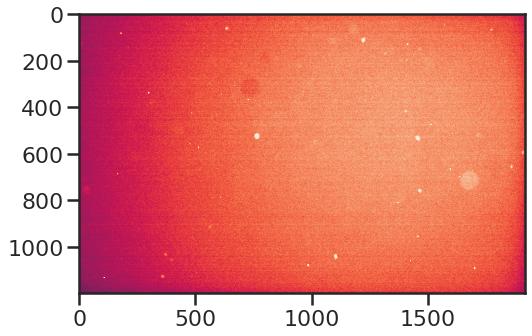

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(channel0example[0,:,:], vmax=np.percentile(channel0example[0,:,:], 99))

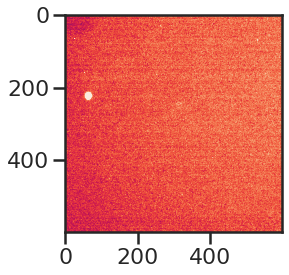

In [13]:
crop = np.s_[300:900, 700:1300]
plt.imshow(channel0example[0,:,:][crop], vmax=np.percentile(channel0example[0,:,:], 99))

# Crop and average

In [14]:
### Hackish extraction dun dun dun
cropAcrossTimes = np.s_[:, 300:900, 700:1300]
summaryResults={}
for atp in ATPconcs:
    thisATPresult=results[atp]
    for pos in range(len(thisATPresult)):
        for channel in range(len(thisATPresult[pos])):
            summaryResults[(atp, pos, channel)]=np.mean(thisATPresult[pos][channel][cropAcrossTimes], axis=(1,2))

Plot intensity vs. time on the same y range for each channel

Text(0.5, 0, 'time')

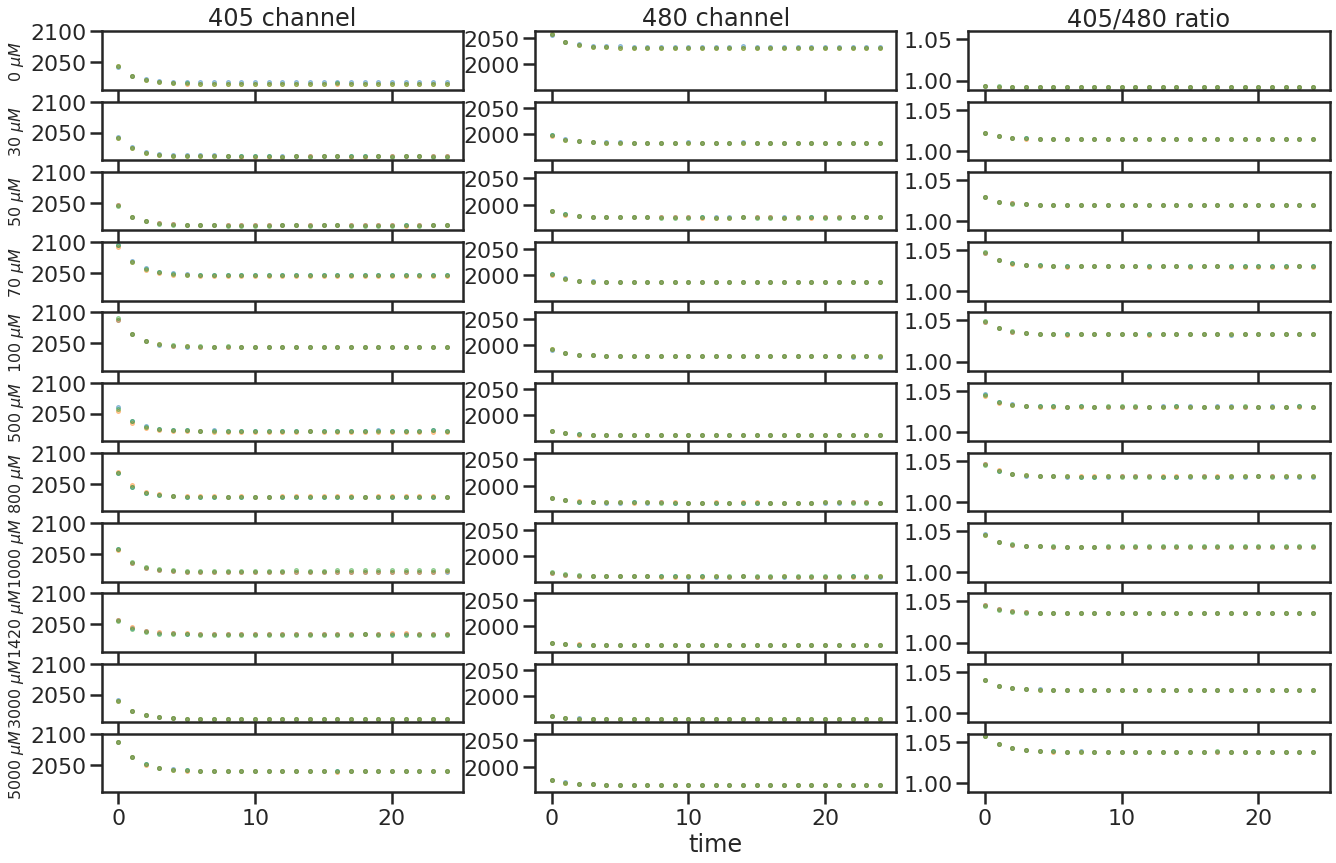

In [15]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(3):
        for col in range(3):
            if col<2:
                ax[a][col].plot(summaryResults[(atp, pos, col)], 'o', ms=4, alpha=0.4) 
            else:
                ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            # ax[a][col].set_yscale('log')
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

Let the scale vary for eeach plot

Text(0.5, 0, 'time')

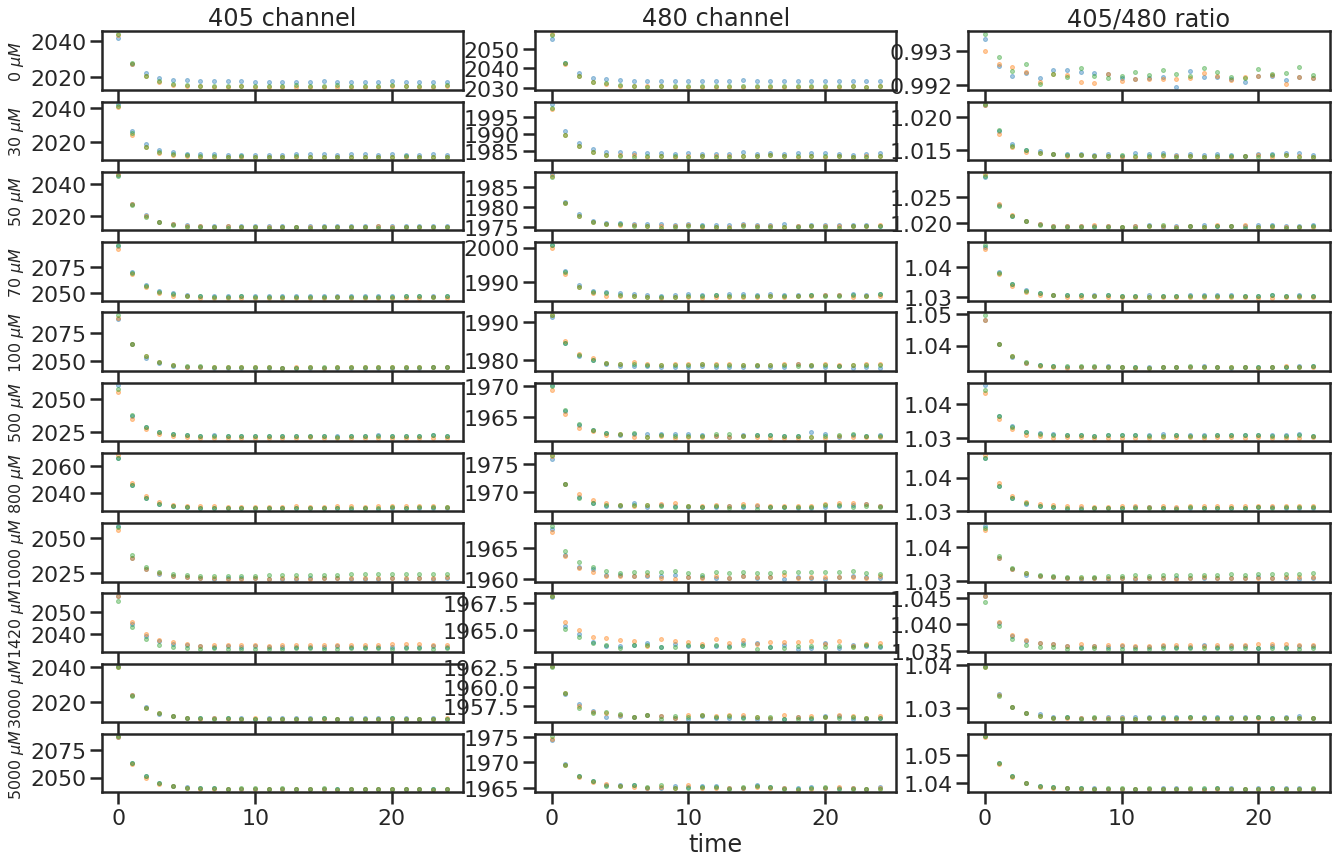

In [16]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14))
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(3):
        for col in range(3):
            if col<2:
                ax[a][col].plot(summaryResults[(atp, pos, col)], 'o', ms=4, alpha=0.4) 
            else:
                ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)

ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

Examine the derivative

Text(0.5, 0, 'time')

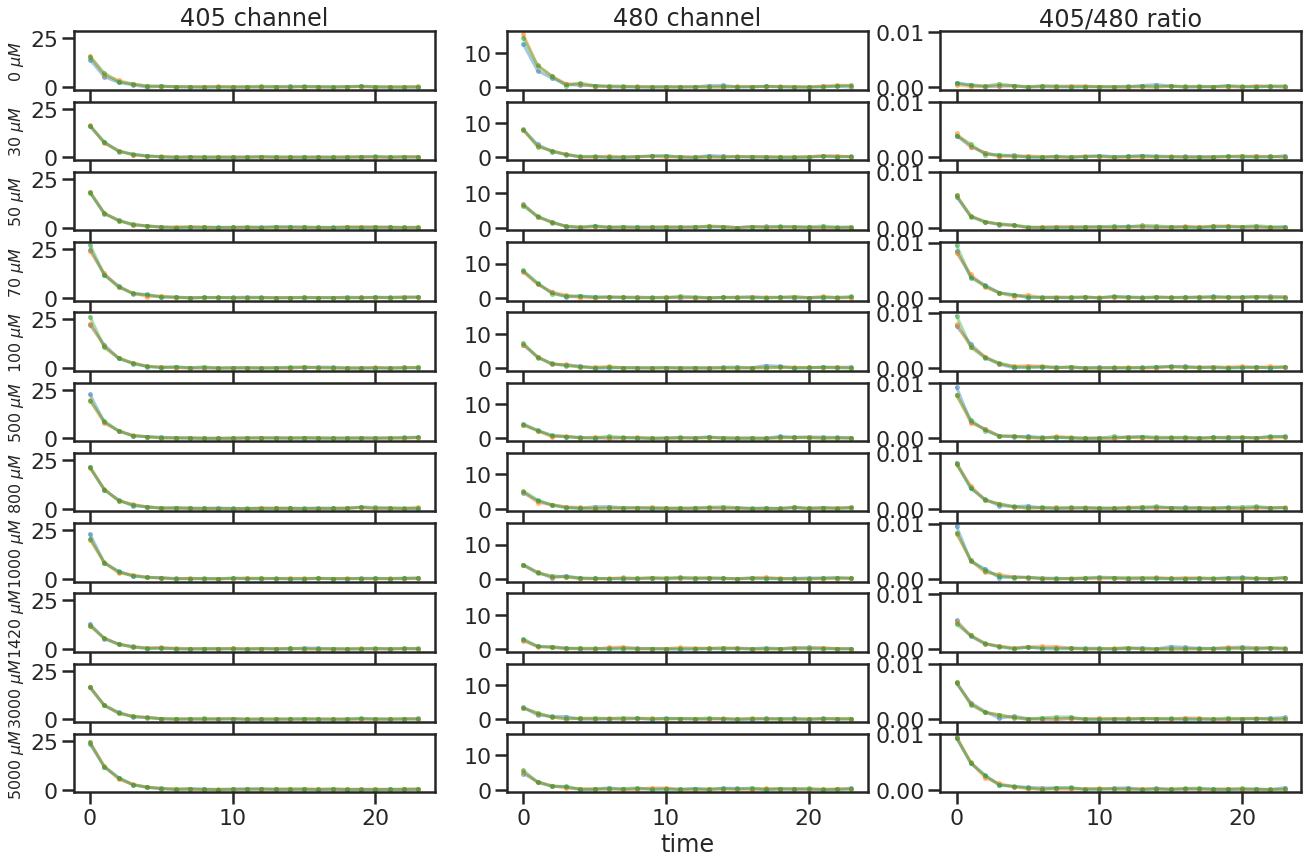

In [17]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(3):
        for col in range(3):
            if col<2:
                ax[a][col].plot(np.abs(np.diff(summaryResults[(atp, pos, col)])), 'o-', ms=4, alpha=0.4) 
            else:
                ax[a][col].plot(np.abs(np.diff(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)])), 'o-', ms=4, alpha=0.4)
            # ax[a][col].set_yscale('log')
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

log scale

Text(0.5, 0, 'time')

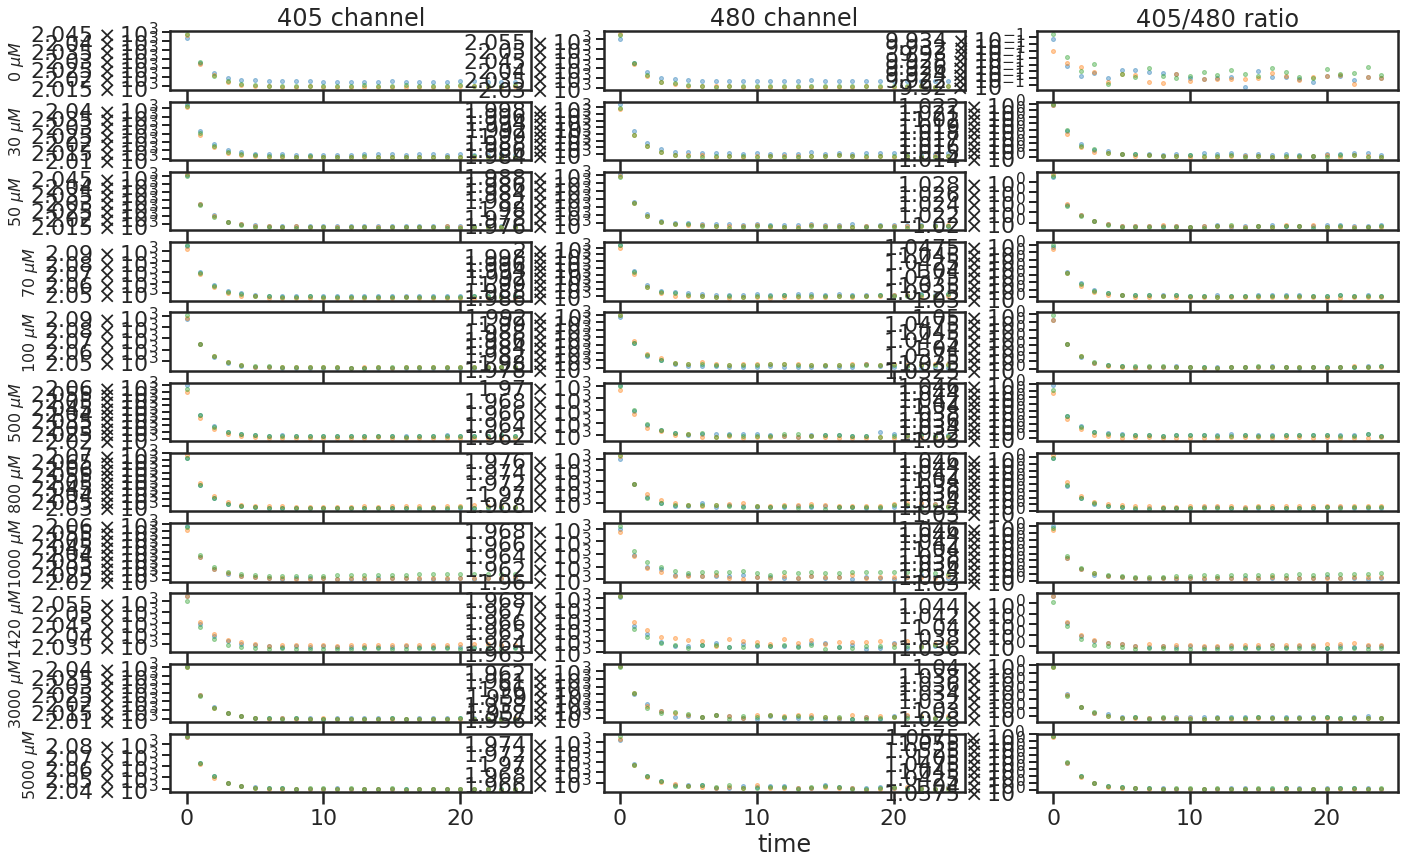

In [18]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14))
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(3):
        for col in range(3):
            if col<2:
                ax[a][col].plot(summaryResults[(atp, pos, col)], 'o', ms=4, alpha=0.4) 
            else:
                ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            ax[a][col].set_yscale('log')

ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

# Do it with fixing uneven illumination

doesnt acount for anomolyous bright spots

In [19]:
def fit_bivariate_quadratic(image):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    image (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Get image dimensions
    M, N = image.shape

    # Create a meshgrid of coordinates
    i = np.arange(M)
    j = np.arange(N)
    I, J = np.meshgrid(i, j, indexing='ij')

    # Flatten the matrices for the least squares fitting
    I_flat = I.flatten()
    J_flat = J.flatten()
    Z_flat = image.flatten()

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly(image):
    """ Evaluates best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic(image);
    I, J = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing='ij')
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted


def norm_unev(arr):
    """
    Corrects uneven illumination by fitting an image to a bivariate polynomial, normalizing the polynomial, and dividing an array of images by this normalized matrix.
    
    Parameters:
    arr (np.array): Dark image subtracted image array.
    allmask_coords (slice): slice containing all the illumination coordinates with an extra dimension to account for all timepoints
    
    Returns:
    arr_ev (np.array): image array after the evening process.
    norm_mat (np.array): array to use to normalize uneven illumination.
    """
    #norm_mats = []
    arrs_ev = []
    
    #compute the bivariate filter
    biv_filt = np.zeros_like(arr[0]) 
    biv_filt = evaluateBivPoly(arr[0, :, :])
    #norm_mats.append(norm_mat)
    #print("time after polynomial fitting", time.time());
    #scale the normalization matrix such that the average value after multiplication is the same as the bs image

    scalar = np.mean(arr[0])/np.mean(arr[0]/biv_filt)

    # Normalisation
    norm_mat = scalar/biv_filt
    # print("shape of norm mat", norm_mat.shape)
    # print("shape of arr", arr.shape)
    # print("time after normalising matrix", time.time());

    arrs_ev = np.zeros_like(arr)
    arrs_ev=arr*norm_mat; 
    #print("time after multiplying arr with norm_mat", time.time());
        
    return arrs_ev

perform uneven illum correction and then average images. For ratios, I took the mean first. If you divide and then take the mean there are NaNs from divide by zeros

In [20]:
file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
dark_avg = grab_dark_avg(file_path_dark)
crop = np.s_[300:900, 700:1300]
cropAcrossTimes = np.s_[:, 300:900, 700:1300]

mask = np.zeros_like(results[0][0][0][0])
mask[crop] = 1

crop_coords = np.where(mask==1)

mask = np.zeros_like(results[0][0][0])
mask[cropAcrossTimes] = 1
allcrop_coords = np.where(mask==1)

tstart=time.time()
evenedResults={}
for a, atp in enumerate(ATPconcs):
    for pos in range(len(results[atp])):
        arrs = results[atp][pos]
        arrs_sub = backSubtract(arrs, dark_avg)
        arrs_405even=norm_unev(arrs_sub[0][cropAcrossTimes])
        arrs_480even=norm_unev(arrs_sub[1][cropAcrossTimes])
        arrs_even = [arrs_405even, arrs_480even]
        #ratios = arrs_even[0]/arrs_even[1]

        evenedResults[(atp, pos, '405')] = np.mean(arrs_405even, axis=(1,2))
        evenedResults[(atp, pos, '480')] = np.mean(arrs_480even, axis=(1,2))
        evenedResults[(atp, pos, 'ratio')] = np.mean(arrs_405even, axis=(1,2))/np.mean(arrs_480even, axis=(1,2)) #np.nanmean(ratios, axis=(1,2)) #mean first
        #evenedResults[(atp, pos, 'ratio')] = np.nanmean(ratios, axis=(1,2)) #divide first

        # Manual Status bar
        print("\r"+str(round((a+1)*100/len(ATPconcs)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")

100%, time elapsed: 31 seconds 

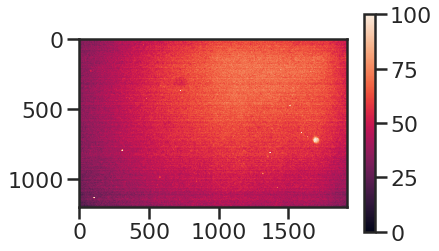

In [47]:
plt.imshow(results[5000][2][1][0]-dark_avg, vmax = 100, vmin= 0)
plt.colorbar()

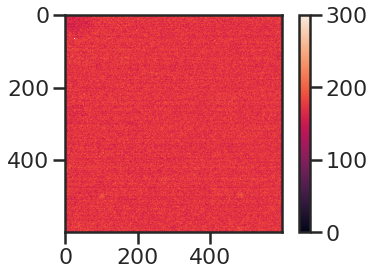

In [50]:
plt.imshow(arrs_405even[0], vmax = 300, vmin= 0)
plt.colorbar()

Text(0.5, 0, 'time')

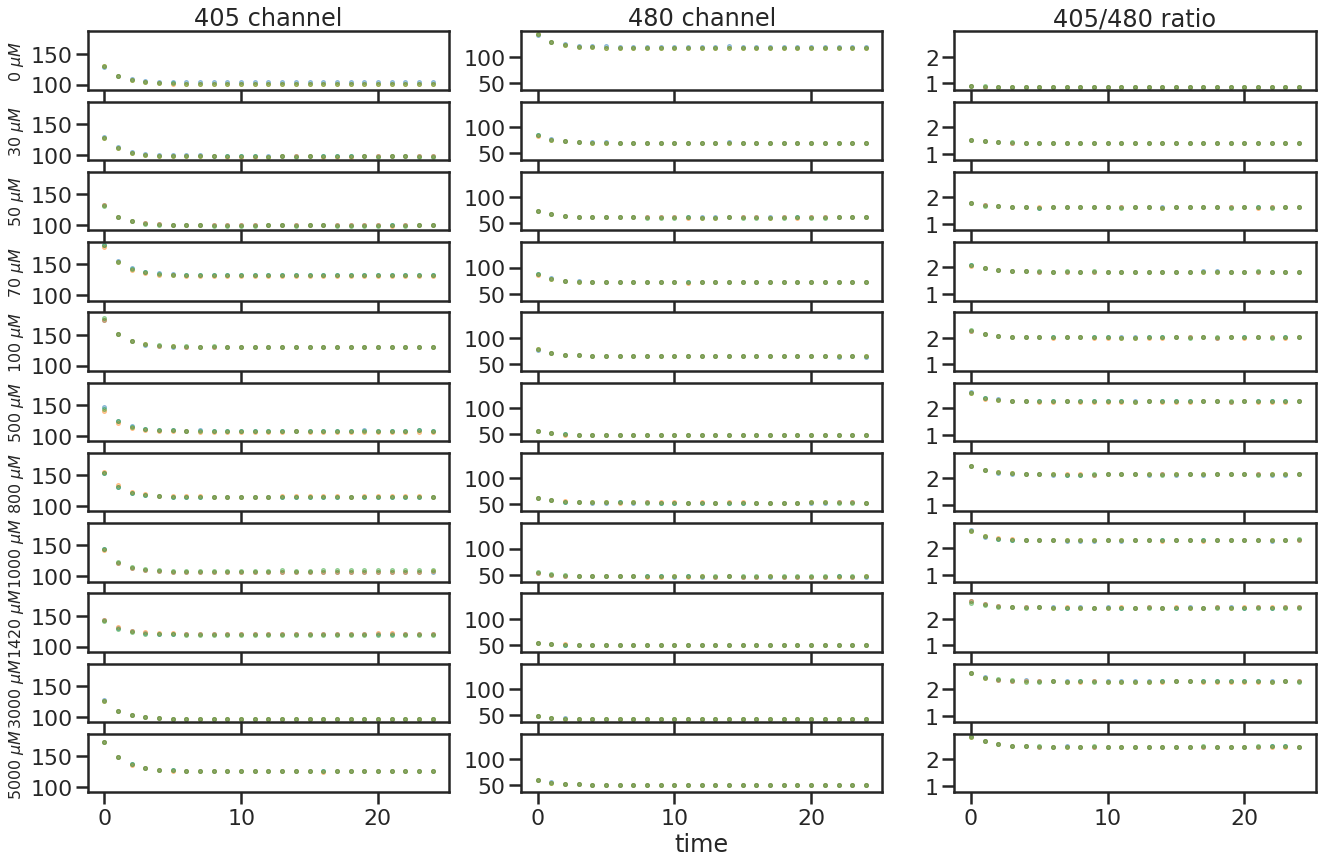

In [22]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(3):
        for col, colname in enumerate(['405', '480', 'ratio']):
            #if col<2:
            ax[a][col].plot(evenedResults[(atp, pos, colname)], 'o', ms=4, alpha=0.4) 
            # else:
            #     ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            # ax[a][col].set_yscale('log')
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

Text(0.5, 0, 'time')

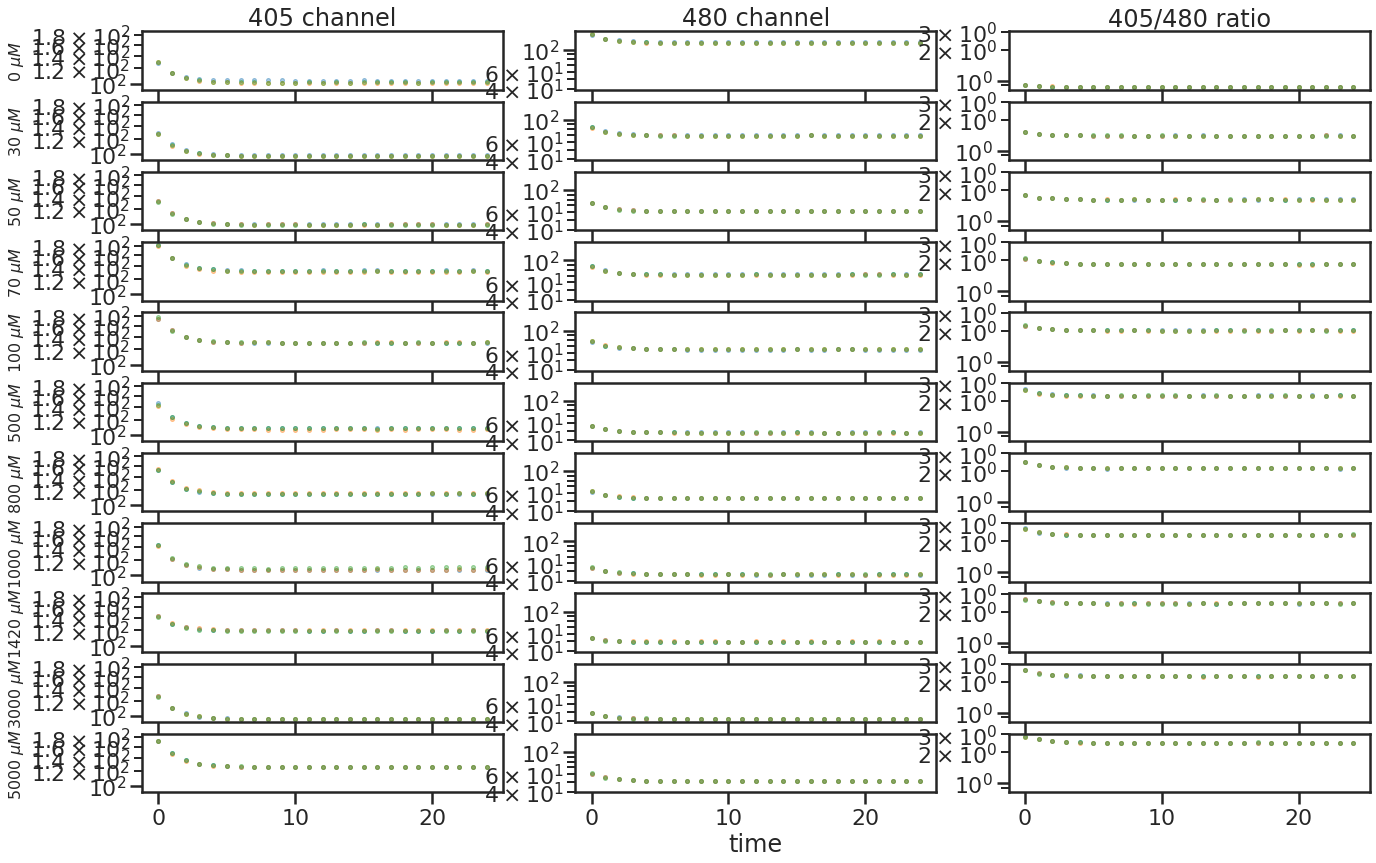

In [23]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(3):
        for col, colname in enumerate(['405', '480', 'ratio']):
            #if col<2:
            ax[a][col].plot(evenedResults[(atp, pos, colname)], 'o', ms=4, alpha=0.4) 
            # else:
            #     ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            ax[a][col].set_yscale('log')
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

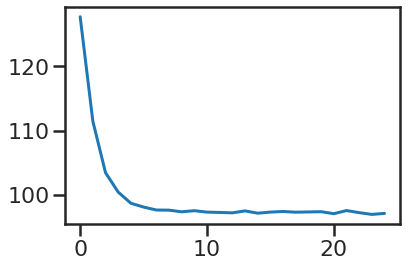

In [24]:
plt.plot(evenedResults[(30, 2, '405')])

## Fitting to a Single Exponential

In [28]:
def singExp(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, Iinf], where w1 is the weight of the exponential, tau1 is the decay constant of the exponential and Iinf is the limit of the intensity
    """
    w1 = p0[0]
    tau1 = p0[1]
    Iinf = p0[2]

    return w1*np.exp(-times/tau1)+Iinf
    
def singExpFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-singExp(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess)
    return result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.627362095438604e-05
        x: [ 2.726e-01  2.736e+01  7.277e-01]
      nit: 6
      jac: [ 2.814e-07 -4.743e-09  5.213e-07]
 hess_inv: [[ 4.883e-01 -3.344e+01 -1.850e-02]
            [-3.344e+01  2.080e+04 -8.207e+00]
            [-1.850e-02 -8.207e+00  2.556e-02]]
     nfev: 60
     njev: 15

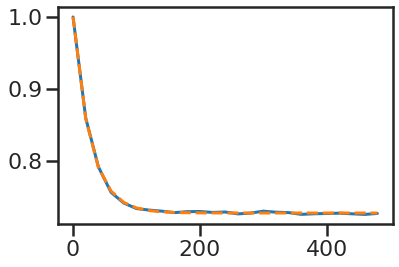

In [29]:
temparr = evenedResults[(5000, 2, '405')]
tempevenarr = temparr/temparr.max()
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = singExpFit(temptimes, tempevenarr, [0.2, 25, 0.8])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])

plt.plot(temptimes, tempevenarr)
plt.plot(temptimes, singExp(temptimes, tempfit.x), ls='--')
tempfit

### Do the Fit to single exponential and store max vals

In [37]:
#fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
tstart = time.time() # to keep track of runtime
singExpFitResults={} #store results of fit
maxVals = {} #store array maximums
for a, atp in enumerate(ATPconcs): 
    for pos in range(3): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            plotarr = evenedResults[(atp, pos, colname)]
            maxVals[atp, pos, colname] = plotarr.max() #store maximums
            plottimes = np.arange(len(plotarr))*20 #seconds 

            #fit the intensity values to a decaying exponential
            #if col<2:
            #normalize the intensity values
            plotnormarr = plotarr/plotarr.max()
            fit = singExpFit(plottimes, plotnormarr, (plotnormarr.max()-plotnormarr.min(), 25, plotnormarr.min()))
            singExpFitResults[atp, pos, colname] = fit
            
    # Manual Status bar
    print("\r"+str(round((a+1)*100/len(ATPconcs)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")

100%, time elapsed: 1 seconds 

### Plot

Text(0.5, 0, 'time')

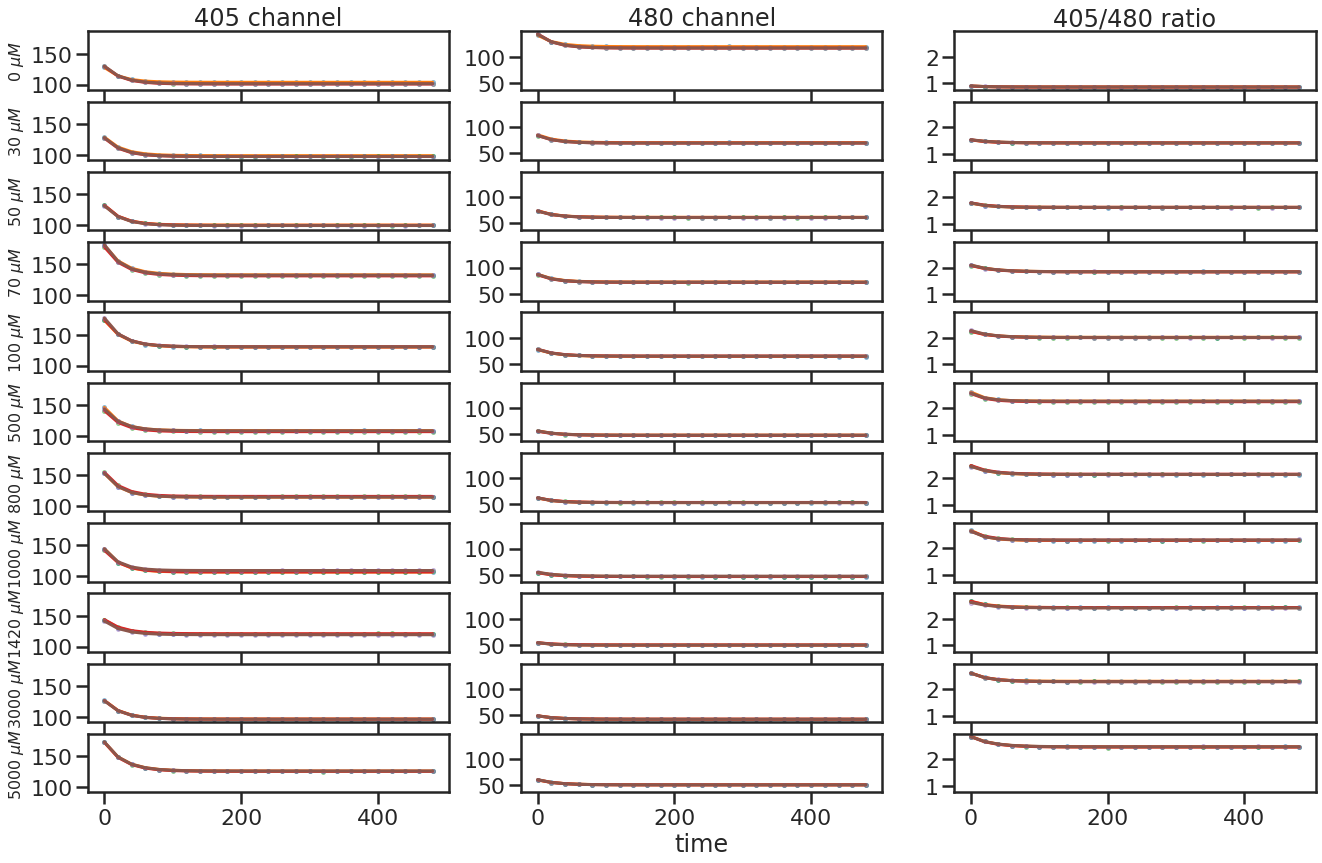

In [45]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs): 
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16) # add axis labels
    for pos in range(3): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            ax[a][col].plot(plottimes, plotarr, 'o', ms=4, alpha=0.4) 

            #fit the intensity values to a decaying exponential
            #if col<2:
            #normalize the intensity values
            plotnormarr = plotarr/plotarr.max()
            ax[a][col].plot(plottimes, singExp(plottimes, singExpFitResults[atp, pos, colname].x)*plotarr.max())
           
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

Text(0.5, 0, 'time')

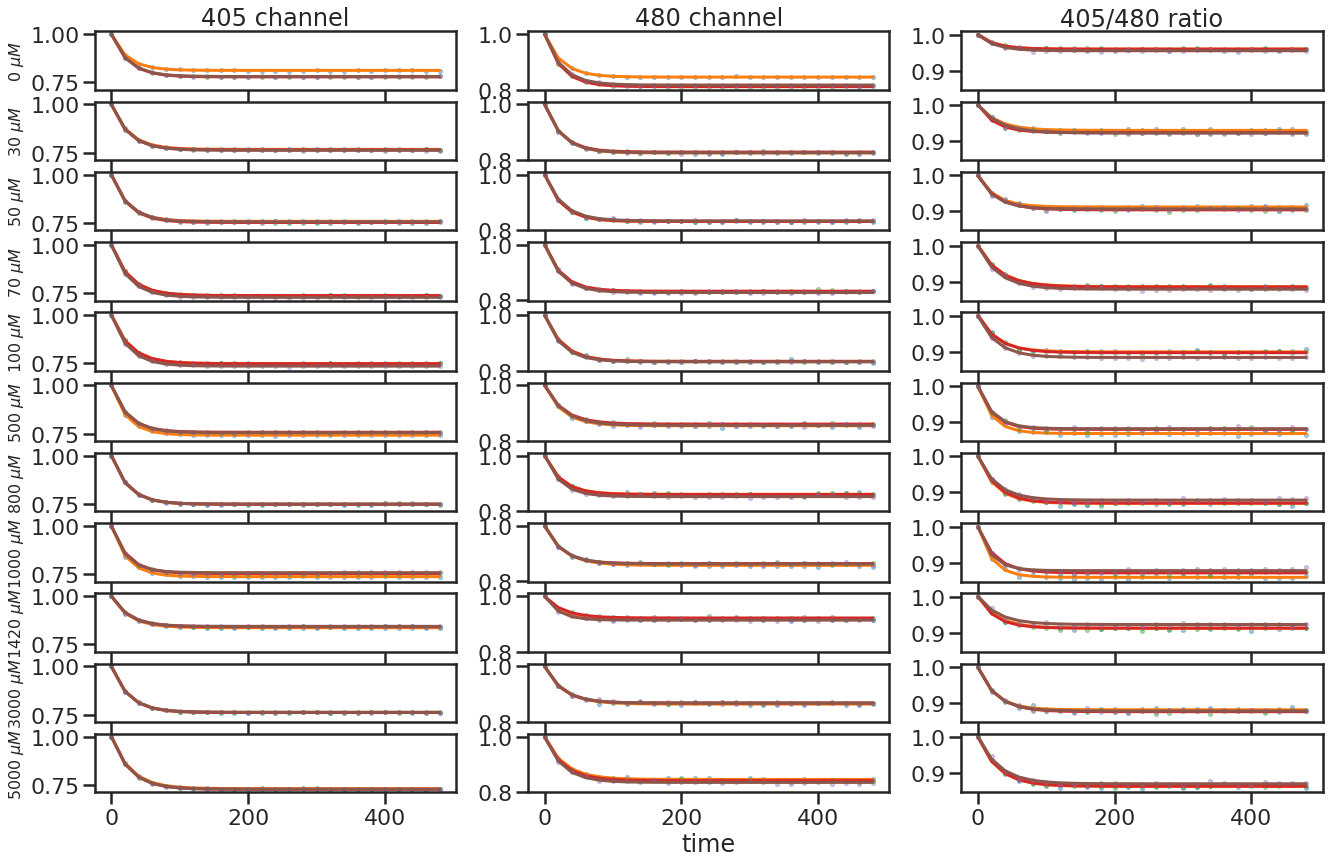

In [46]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs): 
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16) # add axis labels
    for pos in range(3): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            plotnormarr = plotarr/plotarr.max()
            ax[a][col].plot(plottimes, plotnormarr, 'o', ms=4, alpha=0.4) 

        
            ax[a][col].plot(plottimes, singExp(plottimes, singExpFitResults[atp, pos, colname].x))
           
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

In [47]:
singExpFitResults.keys()

dict_keys([(np.int64(0), 0, '405'), (np.int64(0), 0, '480'), (np.int64(0), 0, 'ratio'), (np.int64(0), 1, '405'), (np.int64(0), 1, '480'), (np.int64(0), 1, 'ratio'), (np.int64(0), 2, '405'), (np.int64(0), 2, '480'), (np.int64(0), 2, 'ratio'), (np.int64(30), 0, '405'), (np.int64(30), 0, '480'), (np.int64(30), 0, 'ratio'), (np.int64(30), 1, '405'), (np.int64(30), 1, '480'), (np.int64(30), 1, 'ratio'), (np.int64(30), 2, '405'), (np.int64(30), 2, '480'), (np.int64(30), 2, 'ratio'), (np.int64(50), 0, '405'), (np.int64(50), 0, '480'), (np.int64(50), 0, 'ratio'), (np.int64(50), 1, '405'), (np.int64(50), 1, '480'), (np.int64(50), 1, 'ratio'), (np.int64(50), 2, '405'), (np.int64(50), 2, '480'), (np.int64(50), 2, 'ratio'), (np.int64(70), 0, '405'), (np.int64(70), 0, '480'), (np.int64(70), 0, 'ratio'), (np.int64(70), 1, '405'), (np.int64(70), 1, '480'), (np.int64(70), 1, 'ratio'), (np.int64(70), 2, '405'), (np.int64(70), 2, '480'), (np.int64(70), 2, 'ratio'), (np.int64(100), 0, '405'), (np.int64(1

In [48]:
w1For405 =np.median([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if '405' in k])
tauFor405=np.median([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if '405' in k])
intFor405=np.median([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '405' in k])

w1For480 =np.median([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if '480' in k])
tauFor480=np.median([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if '480' in k])
intFor480=np.median([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '480' in k])

w1Forratio =np.median([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if 'ratio' in k])
tauForratio=np.median([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if 'ratio' in k])
intForratio=np.median([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if 'ratio' in k])

print(w1For405, tauFor405, intFor405)
print(w1For480, tauFor480, intFor480)
print(w1Forratio, tauForratio, intForratio)


0.24501234599103164 24.99999754107892 0.7552375357777457
0.15380049578055022 25.000003237233877 0.8453946803458241
0.11520954424900257 26.857834854297625 0.88457730184607


In [49]:
k=list(singExpFitResults.keys())[-1]
np.sqrt(np.diag(singExpFitResults[k].hess_inv))

array([7.00735563e-01, 2.97794537e+02, 1.60159766e-01])

In [106]:
k

(np.int64(5000), 0, 'ratio')

In [107]:
singExpFitResults[k].hess_inv

array([[ 4.95743866e-01, -6.52070247e+01, -1.94813429e-02],
       [-6.52070247e+01,  8.45664739e+04, -1.68917040e+01],
       [-1.94813429e-02, -1.68917040e+01,  2.57591440e-02]])

In [111]:
### Grab fit parameter uncertainty
unc_w1Forratio =[np.sqrt(np.diag(singExpFitResults[k].hess_inv))[0] for k in singExpFitResults.keys() if 'ratio' in k]
unc_tauForratio=[np.sqrt(np.diag(singExpFitResults[k].hess_inv))[1] for k in singExpFitResults.keys() if 'ratio' in k]
unc_intForratio=[np.sqrt(np.diag(singExpFitResults[k].hess_inv))[-1] for k in singExpFitResults.keys() if 'ratio' in k]
#unc_tauForratio
unc_intForratio

[np.float64(0.15911570462063357),
 np.float64(0.15881599646686606),
 np.float64(0.15926975287717837),
 np.float64(0.16145441724086176),
 np.float64(0.15830565301176872),
 np.float64(0.15819791835076655),
 np.float64(0.1579910418184234),
 np.float64(0.1570166360156736),
 np.float64(0.1612510823221165),
 np.float64(0.15923997954917685),
 np.float64(0.16049655443813718)]

In [113]:
singExpFitResults[k].x[-1]

np.float64(0.8637799856019528)

In [53]:
np.repeat(ATPconcs,3)

array([   0,    0,    0,   30,   30,   30,   50,   50,   50,   70,   70,
         70,  100,  100,  100,  500,  500,  500,  800,  800,  800, 1000,
       1000, 1000, 1420, 1420, 1420, 3000, 3000, 3000, 5000, 5000, 5000])

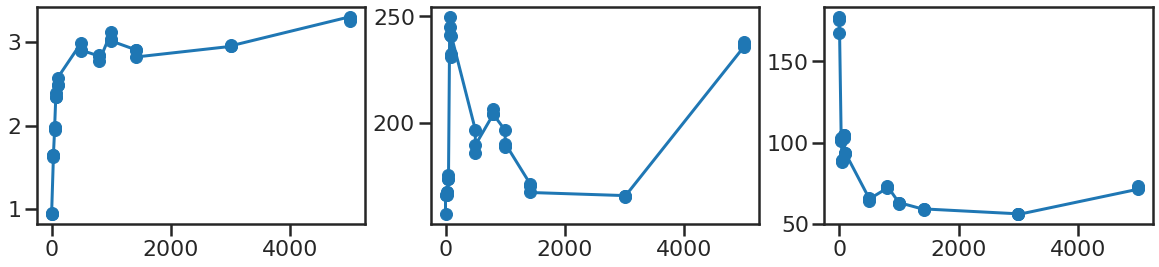

In [54]:
fig, ax = plt.subplots(1,3, figsize = (20, 4))
ax[0].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if 'ratio' in k]) / np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[1].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '405' in k]) / np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '405' in k]), 'o-', label='405')
ax[2].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '480' in k]) / np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '480' in k]), 'o-', label='480') 


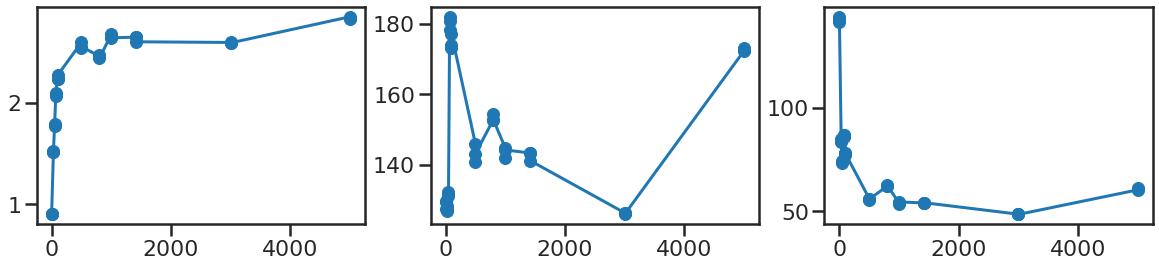

In [56]:
fig, ax = plt.subplots(1,3, figsize = (20, 4))
ax[0].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if 'ratio' in k]) , 'o-',label='ratio')
ax[1].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '405' in k]) , 'o-',label='405')
ax[2].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '480' in k]) , 'o-', label='480') 


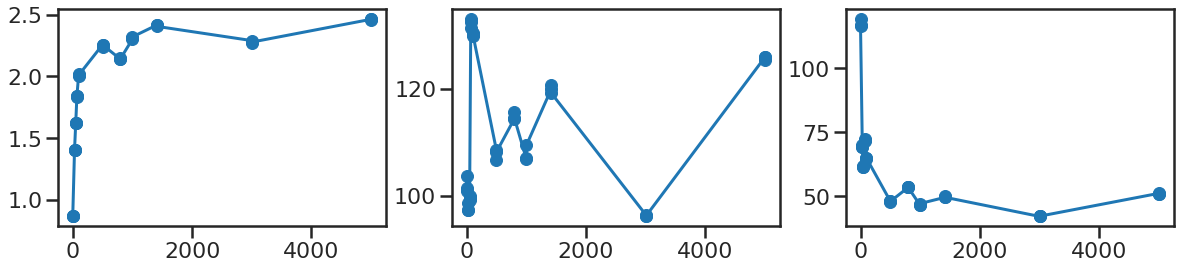

In [57]:
fig, ax = plt.subplots(1,3, figsize = (20, 4))
ax[0].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if 'ratio' in k]) * np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[1].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '405' in k]) * np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '405' in k]), 'o-', label='405')
ax[2].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '480' in k]) * np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '480' in k]), 'o-', label='480') 


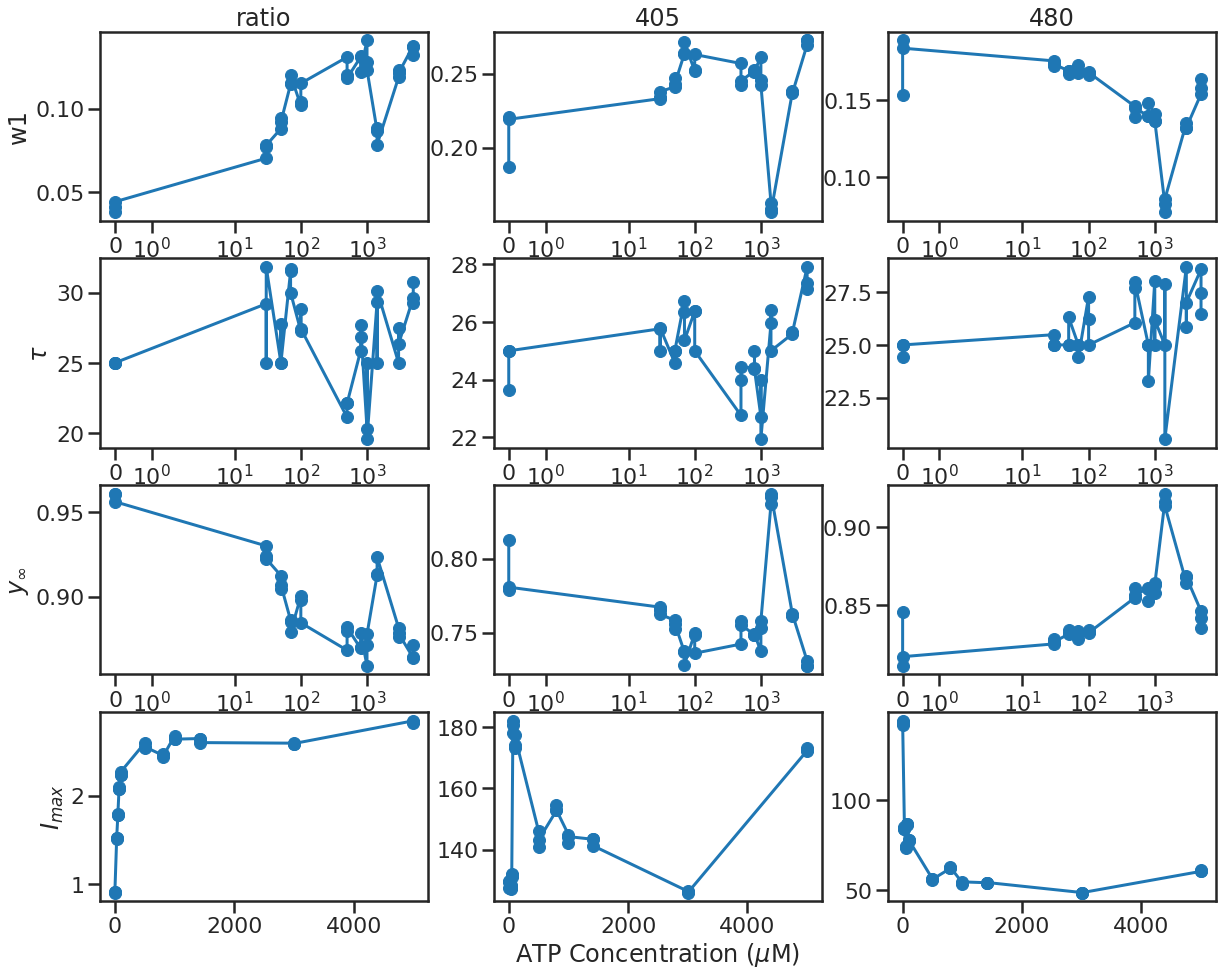

In [75]:
fig, ax = plt.subplots(4,3, figsize = (20, 16))

ax[0][0].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[0][1].plot(np.repeat(ATPconcs,3), np.array([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if '405' in k]), 'o-', label='405')
ax[0][2].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if '480' in k]), 'o-', label='480') 
ax[0][0].set_ylabel('w1')

ax[0][0].set_title('ratio')
ax[0][1].set_title('405')
ax[0][2].set_title('480')


ax[1][0].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[1][1].plot(np.repeat(ATPconcs,3), np.array([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if '405' in k]), 'o-', label='405')
ax[1][2].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if '480' in k]), 'o-', label='480') 
ax[1][0].set_ylabel(r'$\tau$')

ax[2][0].plot(np.repeat(ATPconcs,3), np.array([singExpFitResults[k].x[2] for k in singExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[2][1].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[2] for k in singExpFitResults.keys() if '405' in k]), 'o-', label='405')
ax[2][2].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[2] for k in singExpFitResults.keys() if '480' in k]), 'o-', label='480') 
ax[2][0].set_ylabel(r'$y_\infty$')

ax[3][0].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[3][1].plot(np.repeat(ATPconcs,3),  np.array([maxVals[k] for k in maxVals.keys() if '405' in k]), 'o-', label='405')
ax[3][2].plot(np.repeat(ATPconcs,3),  np.array([maxVals[k] for k in maxVals.keys() if '480' in k]), 'o-', label='480') 
ax[3][0].set_ylabel(r'$I_{max}$')
ax[3][1].set_xlabel(r'ATP Concentration ($\mu$M)')

for i in range(3):
    for j in range(3):
        ax[i][j].set_xscale('symlog')

In [93]:
evenedResults[5000, 0, 'ratio'].max()/singExpFitResults[5000,0,'ratio'].x[2]

np.float64(3.3015130717811285)

KeyError: (1, 0, '405')

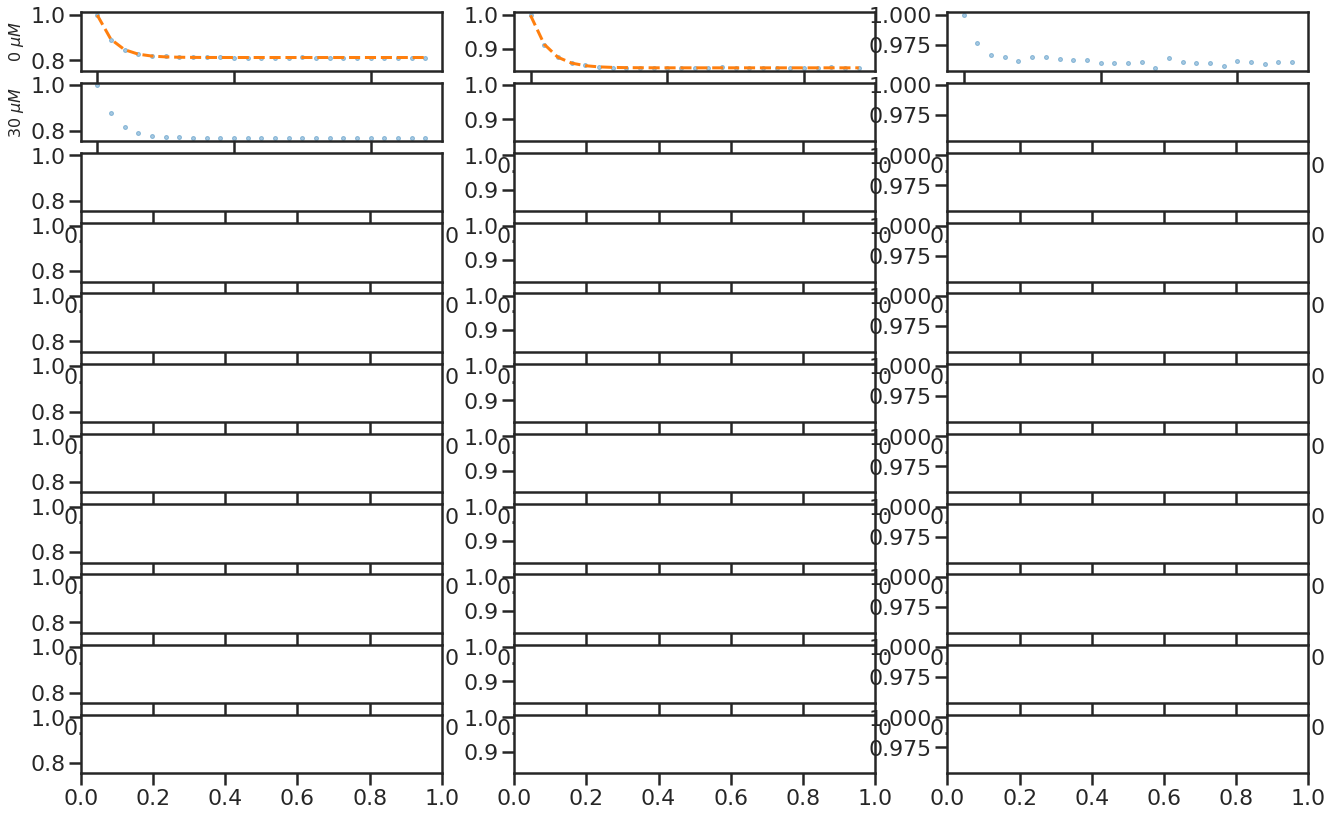

In [61]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs): 
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16) # add axis labels
    for pos in range(1): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            ax[a][col].plot(plottimes, plotarr/plotarr.max(), 'o', ms=4, alpha=0.4)

            if col<2:
                ax[a][col].plot(plottimes, singExp(plottimes, singExpFitResults[(a, 0, colname)].x), ls='--')

KeyError: (0, 0, 0)

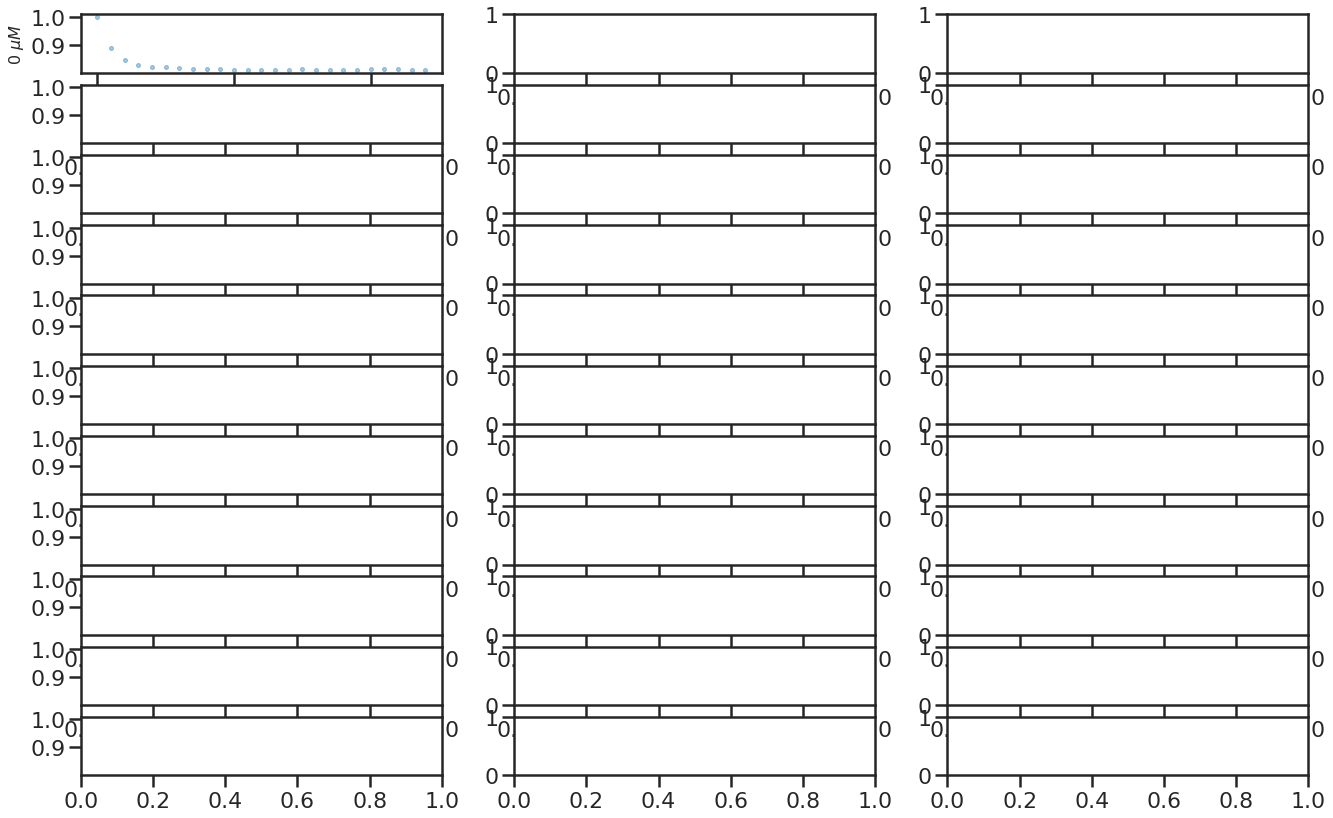

In [55]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
tstart = time.time() # to keep track of runtime
#singExpFitResults={} #store results of fit
for a, atp in enumerate(ATPconcs): 
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16) # add axis labels
    for pos in range(1): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            ax[a][col].plot(plottimes, plotarr/plotarr.max(), 'o', ms=4, alpha=0.4)

            #fit the intensity values to a decaying exponential
            if col<2:
                #normalize the intensity values
                plotnormarr = plotarr/plotarr.max()
                #fit = singExpFit(plottimes, plotnormarr, (plotnormarr.max()-plotnormarr.min(), 25, plotnormarr.min()))
                ax[a][col].plot(plottimes, singExp(plottimes, singExpFitResults[(a, 0, col)].x))
                #singExpFitResults[atp, pos, colname] = fit
            # else:
            #     ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            # ax[a][col].set_yscale('log')
    # Manual Status bar
    print("\r"+str(round((a+1)*100/len(ATPconcs)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

Yippee

In [28]:
singExpFitResults

{(np.int64(0),
  0,
  '405'):   message: Optimization terminated successfully.
   success: True
    status: 0
       fun: 5.740625747608287e-05
         x: [ 1.868e-01  2.365e+01  8.124e-01]
       nit: 6
       jac: [-1.108e-06  5.383e-08  5.852e-06]
  hess_inv: [[ 4.976e-01 -4.648e+01 -1.964e-02]
             [-4.648e+01  4.086e+04 -1.109e+01]
             [-1.964e-02 -1.109e+01  2.535e-02]]
      nfev: 60
      njev: 15,
 (np.int64(0),
  0,
  '480'):   message: Optimization terminated successfully.
   success: True
    status: 0
       fun: 2.702698912799086e-05
         x: [ 1.534e-01  2.500e+01  8.454e-01]
       nit: 2
       jac: [-3.923e-08  9.999e-06  1.644e-08]
  hess_inv: [[ 1.010e+00  2.575e-05 -7.206e-02]
             [ 2.575e-05  1.000e+00 -2.963e-04]
             [-7.206e-02 -2.963e-04  2.514e-02]]
      nfev: 20
      njev: 5,
 (np.int64(30),
  0,
  '405'):   message: Optimization terminated successfully.
   success: True
    status: 0
       fun: 2.3031877852253627e-05

## Fitting to Double Exponential

In [24]:
def doubExp(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, w2, tau2], where w1(2) is the weight of the first(second) exponential, tau1(2) is the decay constant of the first(second) exponential
    """
    w1 = p0[0]
    tau1 = p0[1]
    w2 = p0[2]
    tau2 = p0[3]

    return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
    

In [28]:
def doubExpFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess)
    return result

In [ ]:
temparr = evenedResults[(30, 0, '405')]
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = doubExpFit(temptimes, temparr, (10, 50, 5, 300 ))

/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)


73%, time elapsed: 1 seconds 

/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
/tmp/ipykernel_448096/3042285851.py:11: RuntimeWarning: overflow encountered in exp
  return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
/home/aduarte/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
/tmp/ipykernel_448096/3042285851.py:11: RuntimeWarning: overflow encountered in exp
  return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
/tmp/ipykernel_448096/3042285851.py:11: RuntimeWarning: overflow encountered in exp
  return w1*np.exp(-times/tau1)+w2*np.exp(-time

91%, time elapsed: 1 seconds 

/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
/home/aduarte/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/tmp/ipykernel_448096/3042285851.py:11: RuntimeWarning: overflow encountered in exp
  return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)


100%, time elapsed: 2 seconds 

Text(0.5, 0, 'time')

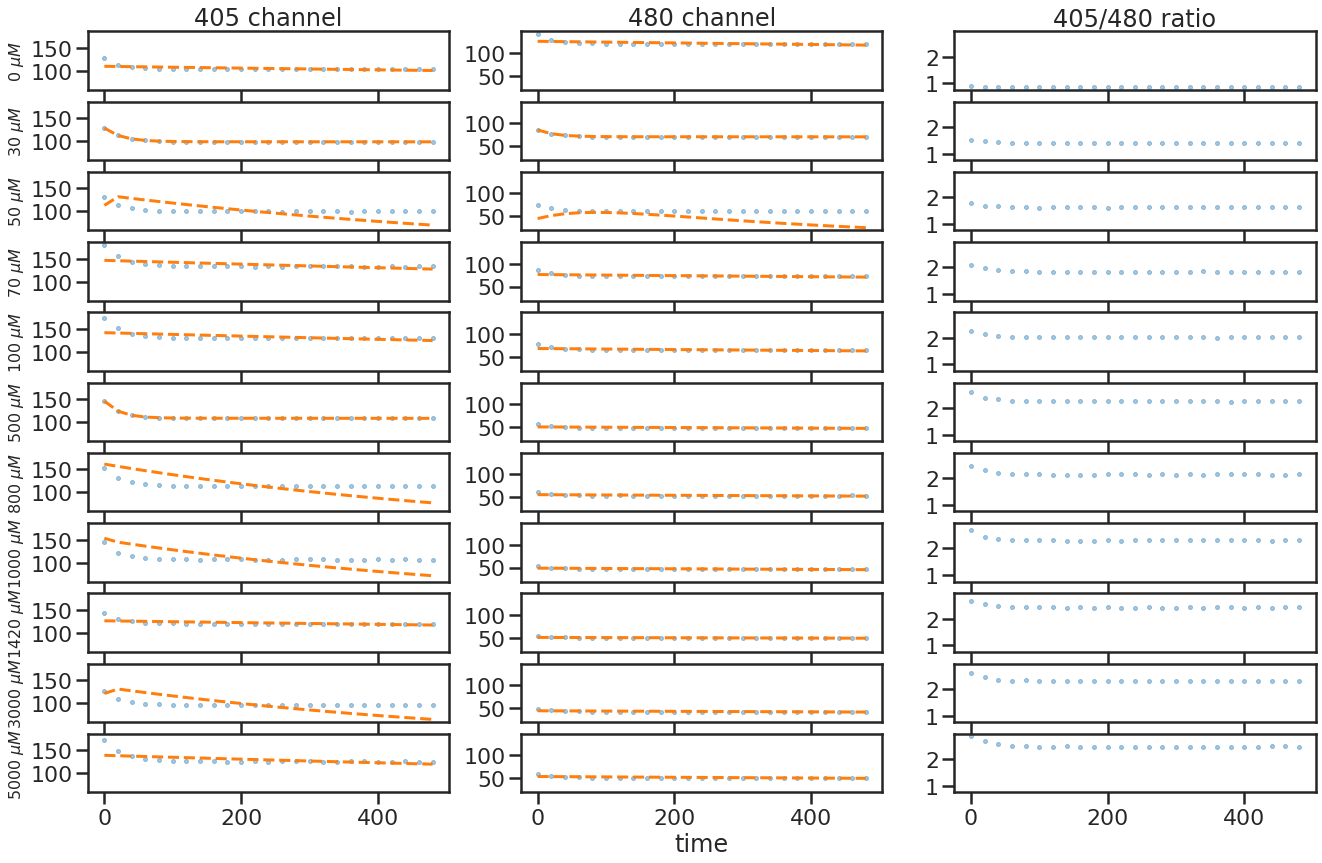

In [59]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
tstart = time.time()
doubExpFitResults={}
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(1):
        for col, colname in enumerate(['405', '480', 'ratio']):

            plottimes = np.arange(len(evenedResults[(atp, pos, colname)]))*20 #seconds
            ax[a][col].plot(plottimes, evenedResults[(atp, pos, colname)], 'o', ms=4, alpha=0.4) 

            if col<2:
                fit = doubExpFit(plottimes, evenedResults[(atp, pos, colname)], (10, 50, 15, 300 ))
                ax[a][col].plot(plottimes, doubExp(plottimes, fit.x))
                doubExpFitResults[atp, pos, colname] = fit
            # else:
            #     ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            # ax[a][col].set_yscale('log')
    # Manual Status bar
    print("\r"+str(round((a+1)*100/len(ATPconcs)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

In [60]:
doubExpFitResults

{(np.int64(0),
  0,
  '405'):   message: Desired error not necessarily achieved due to precision loss.
   success: False
    status: 2
       fun: 442.40177120377376
         x: [ 2.982e+01  2.985e+03  8.023e+01  7.826e+03]
       nit: 42
       jac: [-2.556e-04  8.240e-04  8.011e-04 -3.357e-04]
  hess_inv: [[ 8.481e+01  1.320e+03 -8.281e+01  3.089e+03]
             [ 1.320e+03  3.459e+04 -1.309e+03  8.258e+04]
             [-8.281e+01 -1.309e+03  8.090e+01 -3.066e+03]
             [ 3.089e+03  8.258e+04 -3.066e+03  1.972e+05]]
      nfev: 434
      njev: 84,
 (np.int64(0),
  0,
  '480'):   message: Desired error not necessarily achieved due to precision loss.
   success: False
    status: 2
       fun: 377.1621667061019
         x: [-7.300e+01  6.789e+03  1.982e+02  6.950e+03]
       nit: 63
       jac: [ 2.442e-02 -2.289e-05  2.443e-02  1.907e-05]
  hess_inv: [[ 1.268e+03  1.043e+03 -1.260e+03 -4.509e+03]
             [ 1.043e+03  8.577e+02 -1.036e+03 -3.708e+03]
             [-1.260

In [52]:
temparr = evenedResults[(30, 0, '405')]
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = doubExpFit(temptimes, temparr, (10, 50, 5, 300 ))

In [53]:
tempfit.x

array([2.98392383e+01, 2.54884934e+01, 9.87514545e+01, 2.16805966e+05])

In [54]:
temptimes

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
       260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480])

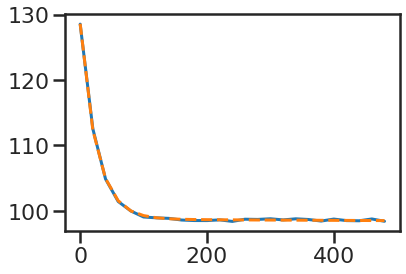

In [58]:
plt.plot(temptimes, evenedResults[(30, 0, '405')])
plt.plot(temptimes, doubExp(temptimes, [2.98392383e+01, 2.54884934e+01, 9.87514545e+01, 2.16805966e+05]), ls='--')

## try normalizing

In [81]:
def singExp(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, Iinf], where w1 is the weight of the exponential, tau1 is the decay constant of the exponential and Iinf is the limit of the intensity
    """
    w1 = p0[0]
    tau1 = p0[1]
    Iinf = p0[2]

    return w1*np.exp(-times/tau1)+Iinf
    
def singExpFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-singExp(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess)
    return result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.627362095438604e-05
        x: [ 2.726e-01  2.736e+01  7.277e-01]
      nit: 6
      jac: [ 2.814e-07 -4.743e-09  5.213e-07]
 hess_inv: [[ 4.883e-01 -3.344e+01 -1.850e-02]
            [-3.344e+01  2.080e+04 -8.207e+00]
            [-1.850e-02 -8.207e+00  2.556e-02]]
     nfev: 60
     njev: 15

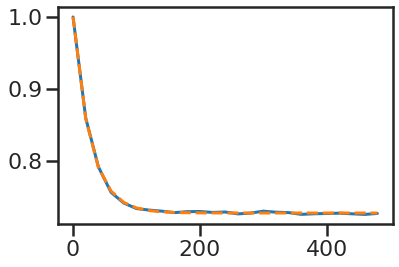

In [83]:
temparr = evenedResults[(5000, 2, '405')]
tempnormarr = temparr/temparr.max()
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = singExpFit(temptimes, tempnormarr, [0.2, 25, 0.8])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])

plt.plot(temptimes, tempnormarr)
plt.plot(temptimes, singExp(temptimes, tempfit.x), ls='--')
tempfit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.7523687655807497e-05
        x: [ 2.321e-01  2.549e+01  7.683e-01  2.168e+05]
      nit: 0
      jac: [ 1.061e-08 -4.547e-13  3.284e-07  3.865e-12]
 hess_inv: [[1 0 0 0]
            [0 1 0 0]
            [0 0 1 0]
            [0 0 0 1]]
     nfev: 5
     njev: 1

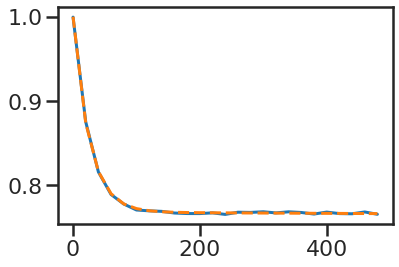

In [72]:
temparr = normedResults[(30, 0, '405')]
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = doubExpFit(temptimes, temparr/temparr.max(), [2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])

plt.plot(temptimes, temparr/temparr.max())
plt.plot(temptimes, doubExp(temptimes, tempfit.x), ls='--')
tempfit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.165363217309855e-05
        x: [ 2.368e-01  2.550e+01  7.634e-01  2.000e+05]
      nit: 6
      jac: [ 1.583e-07 -7.562e-10 -7.654e-07  1.501e-11]
 hess_inv: [[ 4.811e-01 -3.601e+01 -1.668e-02  8.002e-05]
            [-3.601e+01  2.527e+04 -8.679e+00 -5.615e-02]
            [-1.668e-02 -8.679e+00  2.467e-02  1.928e-05]
            [ 8.002e-05 -5.615e-02  1.928e-05  1.000e+00]]
     nfev: 75
     njev: 15

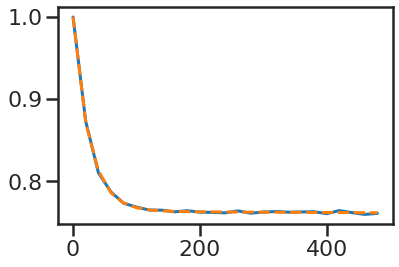

In [75]:
temparr = normedResults[(30, 2, '405')]
tempnormarr = temparr/temparr.max()
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = doubExpFit(temptimes, tempnormarr, [0.2, 25, 0.8, 200000])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])

plt.plot(temptimes, tempnormarr)
plt.plot(temptimes, doubExp(temptimes, tempfit.x), ls='--')
tempfit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00039617608998355076
        x: [ 2.416e-01  2.171e+01  7.590e-01  2.000e+05]
      nit: 7
      jac: [ 4.095e-07  1.601e-09  8.959e-07 -2.619e-10]
 hess_inv: [[ 4.861e-01 -2.731e+01 -2.291e-02  1.079e-04]
            [-2.731e+01  1.869e+04 -6.738e+00 -7.387e-02]
            [-2.291e-02 -6.738e+00  2.479e-02  2.663e-05]
            [ 1.079e-04 -7.387e-02  2.663e-05  1.000e+00]]
     nfev: 80
     njev: 16

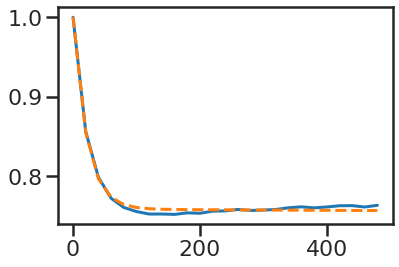

In [80]:
temparr = normedResults[(1000, 2, '405')]
tempnormarr = temparr/temparr.max()
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = doubExpFit(temptimes, tempnormarr, [0.2, 25, 0.8, 200000])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])

plt.plot(temptimes, tempnormarr)
plt.plot(temptimes, doubExp(temptimes, tempfit.x), ls='--')
tempfit

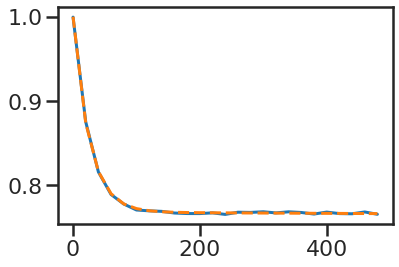

In [71]:
plt.plot(temptimes, normedResults[(30, 0, '405')]/temparr.max())
plt.plot(temptimes, doubExp(temptimes, [2.98392383e+01, 2.54884934e+01, 9.87514545e+01, 2.16805966e+05])/temparr.max(), ls='--')

In [78]:
ATPconcs

array([   0,   30,   50,   70,  100,  500,  800, 1000, 1420, 3000, 5000])

In [ ]:
def gauss2Dfit(vals, coord):
    residual=lambda pvec: np.sum((vals-evalGauss2Dsimple(coord, pvec))**2)
    initialGuess=(np.median(coord[0]), np.median(coord[1]), np.std(coord[0]), np.percentile(vals, 99))
    print(initialGuess)
    bounds=[(min(coord[0]), max(coord[0])), #limits on muy are the image coordinates subsampled on display!
            (min(coord[1]), max(coord[1])), #limits on mux are ^""
            (0, 5000), #limits on sigma are just positivity
            (0, None)] #limits on I0 are just positivity: GOOD VIBES ONLY
    result=scipy.optimize.minimize(residual, initialGuess, method='L-BFGS-B', options={'gtol':1e-7, 'maxiter':1000})

    return result 

######### the above works for normalization ########


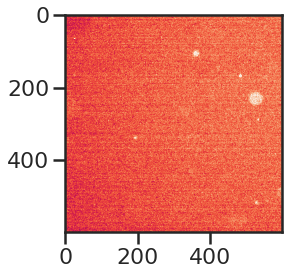

In [191]:
testim = arrs_sub[0][cropAcrossTimes][0]
plt.imshow(testim, vmax=np.percentile(testim, 99))

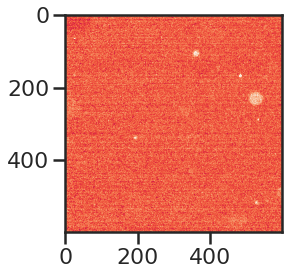

In [190]:
testim = arrs_norm[0][0]
plt.imshow(testim, vmax=np.percentile(testim, 99))

In [149]:
mask = np.zeros_like(results[0][0][0])
print(np.sum(mask>0))
mask[cropAcrossTimes] = 1
print(np.sum(mask>0))
allcrop_coords = np.where(mask==1)

0
9000000


In [152]:
crop_coords

(array([300, 300, 300, ..., 899, 899, 899]),
 array([ 700,  701,  702, ..., 1297, 1298, 1299]))

In [151]:
allcrop_coords


(array([ 0,  0,  0, ..., 24, 24, 24]),
 array([300, 300, 300, ..., 899, 899, 899]),
 array([ 700,  701,  702, ..., 1297, 1298, 1299]))

In [168]:
file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
dark_avg = grab_dark_avg(file_path_dark)
crop = np.s_[300:900, 700:1300]
cropAcrossTimes = np.s_[:, 300:900, 700:1300]

mask = np.zeros_like(results[0][0][0][0])
mask[crop] = 1
crop_coords = np.where(mask==1)

mask = np.zeros_like(results[0][0][0])
mask[cropAcrossTimes] = 1
allcrop_coords = np.where(mask==1)


normedResults={}
for atp in ATPconcs[0:1]:
    for pos in range(len(results[atp])):
        arrs = results[atp][pos]
        arrs_sub = backSubtract(arrs, dark_avg)
        arrs_norm=norm_unev(arrs_sub, crop_coords, cropAcrossTimes)
        #ratios = arrs_norm[0][allcrop_coords]/arrs_norm[1][allcrop_coords]

/tmp/ipykernel_440503/3365823086.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


(360000,)


ValueError: operands could not be broadcast together with shapes (25,600,600) (360000,) 

In [174]:
results[0][0][0].shape

(25, 1200, 1920)

In [173]:
results[0][0][0][0].shape

(1200, 1920)

In [166]:
arrs_sub[0][cropAcrossTimes].shape

(25, 600, 600)

In [169]:
len(arrs_sub)

2

In [170]:
arrs_sub[0].shape

(25, 1200, 1920)

In [171]:
arrs_sub[0][crop_coords]

IndexError: index 300 is out of bounds for axis 0 with size 25

In [172]:
crop_coords

(array([300, 300, 300, ..., 899, 899, 899]),
 array([ 700,  701,  702, ..., 1297, 1298, 1299]))

In [161]:
25*600*600

9000000

In [141]:
allcrop_coords[0].shape, crop_coords[0].shape

((9000000,), (360000,))

In [127]:
arrs_sub[1][allcrop_coords]

array([168.        , 144.        , 114.66666667, ..., 106.66666667,
       138.66666667, 117.33333333])